In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## 1. Data 불러오기

- Boston 집값 Dataset을 가져옵니다.
- 해당 Dataset은 Scikit Learn에서 불러오면 Ethic Issue로, 연구목적으로만 사용하라고 뜨게 됩니다. (우리는 연구 목적이라..)
- 따라서 직접 Dataset을 불러옵니다.

In [28]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

- 데이터를 Training, Testing Set으로 나눕니다.
- Model은 간단히 Linear Regression 모델을 사용합니다.

In [29]:
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state=4096)
linear_model = LinearRegression()

## 2. Genetic Algorithm 구현 (Step by Step)

## Step 1
- Population을 초기화 합니다. (Random 0, 1으로 초기화 합니다.)

In [30]:
# Step 1. Initialization
num_features = x_train.shape[1] 
num_population = 20 # hyper-parms for the number of population

def create_init_chromosome(num_features):
    chromosome_instance = [random.randrange(2) for _ in range(num_features)]
    return chromosome_instance


population = [create_init_chromosome(num_features) for _ in range(num_population)]

In [31]:
population

[[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
 [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1],
 [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
 [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1],
 [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
 [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
 [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
 [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1],
 [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]]

In [32]:
np.array(population).shape

(20, 13)

## Step 2 and 3
- Step 2에서는 Linear Model을 Fitting합니다.
- Step 3에서는 Fitting된 모델을 Evaluation해서 Score를 저장 해 둡니다.

In [33]:
# Step 2. Fitting Models & Step 3. Fitness Evaluation

# calculate chromosome scores
score = -99999

def calc_score(population):
    scores_chromosome = []
    for chromosome in population:
        if sum(chromosome) == 0: # Chromosome에 1이 하나도 없을 때
            score = -999999 
        else:
            chromosome_selected = [bool(chromo) for chromo in chromosome] 
            x_train_selected = x_train[:, chromosome_selected]
            X_test_selected = x_test[:, chromosome_selected]

            linear_model.fit(x_train_selected, y_train)
            score = linear_model.score(X_test_selected, y_test) 

        scores_chromosome.append(score)
    return scores_chromosome

scores_chromosome = calc_score(population)


## Step 4
- Score를 기반으로 Parent Chromosome을 선택합니다.
- 생성된 Population의 상위 50%만을 Parent로 선택합니다.

In [34]:
# Step 4. Select Parent Chromosome
num_deterministic_selection = int(np.round(num_population * 0.5))

parent_chromosome_index = np.array(scores_chromosome).argsort()[-num_deterministic_selection:]
# best_parent_chromosome_index = np.array(scores_chromosome).argsort()[-1]

candidate_parent_chromosome = np.array(population)[parent_chromosome_index]
candidate_parent_score = np.array(scores_chromosome)[parent_chromosome_index]
curr_best_parent_chromosome = np.array(population)[parent_chromosome_index][-1]
curr_best_parent_score = np.array(scores_chromosome)[parent_chromosome_index][-1]
print(curr_best_parent_score)



0.6246927399760429


## Step 5 & 6
- Generation Iteration을 통하여 Crossover와 Mutation을 동시에 진행
- 새로운 Child Chromosome으로 구성된 Population을 만들어냄
- 가장 좋은 Best(Elite) Chromosome은 Population에 항상 1개를 추가함

In [35]:
# Step 5. Crossover, Step 6. Mutation - Generation Iteration 
max_generation = 800
score_history = []


for generation in range(max_generation):
    childs = []
    childs.append(curr_best_parent_chromosome) # Best는 무조건 1개 넣어준다.

    while len(childs) < num_population :
        # 현재의 선택된 Best Parenet 중에서 random으로 좋은 애들 2개를 선택함
        select_2 = random.sample(list(range(len(candidate_parent_score))), 2)
        winner_p1 = candidate_parent_chromosome[min(select_2, key=lambda idx: candidate_parent_score[idx])]

        select_2 = random.sample(list(range(len(candidate_parent_score))), 2)
        winner_p2 = candidate_parent_chromosome[min(select_2, key=lambda idx: candidate_parent_score[idx])]
        
        # cross-over
        c1 = []
        c2 = []
        for i in range(len(winner_p1)):
            if random.random() < 0.5: # Random Crossover (50%)
                c1.append(winner_p1[i])
                c2.append(winner_p2[i])
            else:
                c1.append(winner_p2[i])
                c2.append(winner_p1[i])
        
        # mutation
        if random.random() <= 0.2:
            idx_mutation = random.randrange(0,len(c1))
            c1[idx_mutation] = 1 - c1[idx_mutation]
        if random.random() <= 0.2:
            idx_mutation = random.randrange(0,len(c2))
            c2[idx_mutation] = 1 - c2[idx_mutation]
        
        childs.append(c1)
        if len(childs) < num_population:
            childs.append(c2)
    


    score_history.append([generation, np.max(scores_chromosome), np.std(scores_chromosome)])

    population = childs 
    scores_chromosome = calc_score(population)    
    
    num_deterministic_selection = int(np.round(num_population * 0.5))

    parent_chromosome_index = np.array(scores_chromosome).argsort()[-num_deterministic_selection:]

    candidate_parent_chromosome = np.array(population)[parent_chromosome_index]
    candidate_parent_score = np.array(scores_chromosome)[parent_chromosome_index]

    curr_best_parent_chromosome = np.array(population)[parent_chromosome_index][-1]
    curr_best_parent_score = np.array(scores_chromosome)[parent_chromosome_index][-1]
    print(curr_best_parent_score)


best_index = np.argmax(candidate_parent_score)
best_score = candidate_parent_score[best_index]
best_parent_chromosome = candidate_parent_chromosome[best_index]

        



0.6246927399760429
0.6246927399760429
0.6246927399760429
0.6667583317160046
0.6714905739359212
0.6714905739359212
0.678050876405886
0.6910390327918525
0.6910390327918525
0.6910390327918525
0.6910390327918525
0.6910390327918525
0.6910390327918525
0.6910390327918525
0.6910390327918525
0.6910390327918525
0.6964189519890651
0.6964189519890651
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.7145840328881579
0.71458403288

- Scoe History를 저장한다.

In [36]:
score_history = np.array(score_history)

- Best Chromosome을 찾아서, 해당 Score를 출력하고 선택된 Feature를 표현한다.

In [37]:
print(f'Best Score : {best_score}')
print(f'Best Parent Chromosome : {best_parent_chromosome}')



Best Score : 0.7201593899573326
Best Parent Chromosome : [1 1 0 0 1 0 1 1 1 0 1 1 1]


- Generation에 따른 Score의 변화를 그려준다.

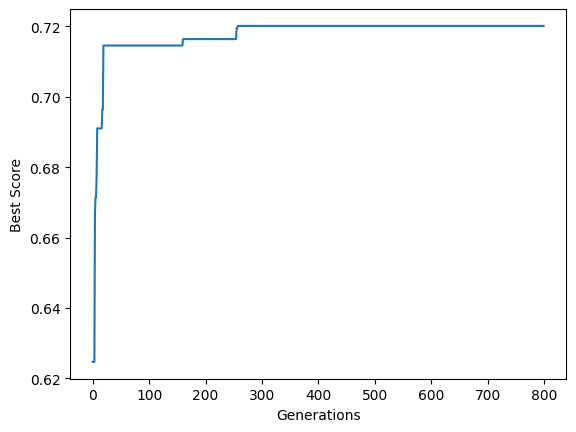

In [38]:
plt.plot(score_history[:, 0], score_history[:, 1])
plt.xlabel("Generations")
plt.ylabel("Best Score")
plt.show()

- Population의 Score Standard deviation을 표현해 준다.
- 얼마나 돌연변이 등으로 수렴이 변화하는지 표현 해 준다.

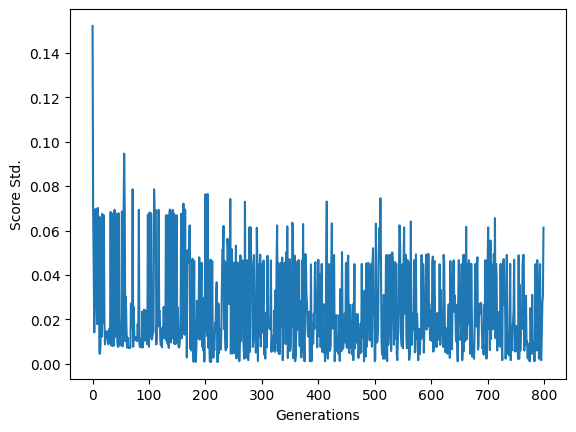

In [39]:
plt.plot(score_history[:, 0], score_history[:, 2])
plt.xlabel("Generations")
plt.ylabel("Score Std.")
plt.show()